In [1]:
#This notebook is based on https://github.com/LSSTDESC/DC2-analysis/blob/u/erykoff/redmapper/contributed/redmapper_python1.ipynb

In [2]:
import GCRCatalogs
from astropy.table import Table
import esutil
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from cluster_validation.association_methods import *
from cluster_validation.plotting_functions import *
from cluster_validation.association_statistics import *
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams.update({'font.size': 18})
#plt.rcParams['figure.figsize'] = [10, 8] for big figures

/pbs/home/m/mricci/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
plt.rcParams.update({'font.size': 18})

# 0 - opening catalogs

In [4]:
# Get the redMaPPer catalog
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.2.1py')

In [5]:
# Select out the cluster and member quantities into different lists
quantities = gc.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]
print (cluster_quantities)

['dec', 'p_cen_1', 'p_cen_4', 'redshift_err', 'cluster_id', 'dec_cen_1', 'id_cen_2', 'id_cen_3', 'ra_cen_1', 'richness', 'scaleval', 'ra', 'p_cen_0', 'id_cen_0', 'ra_cen_0', 'ra_cen_2', 'dec_cen_2', 'p_cen_3', 'dec_cen_3', 'ra_cen_4', 'dec_cen_4', 'maskfrac', 'p_cen_2', 'redshift_true_cg', 'ra_cen_3', 'id_cen_4', 'dec_cen_0', 'redshift', 'id_cen_1', 'richness_err']


In [14]:
# Read in the cluster and member data
cluster_data = Table(gc.get_quantities(cluster_quantities))
member_data = Table(gc.get_quantities(member_quantities))

In [15]:
#read in the "truth" catalog as a comparison (can take a while...)
#gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4')

In [17]:
quantities_wanted = ['mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst', 'redshift','halo_mass','halo_id','galaxy_id','ra','dec']
query = GCRCatalogs.GCRQuery('(is_central == True) & (halo_mass > 5e13)')
truth_data = Table(gc_truth.get_quantities(quantities_wanted, [query]))

In [18]:
print("number of elements in the truth catalog = ", len(truth_data))
print("number of elements in the detection catalog = ", len(cluster_data))

number of elements in the truth catalog =  31959
number of elements in the detection catalog =  4768


# 1 - basic visualization

In [19]:
print("catalog sky area = ", gc_truth.sky_area, "deg2")

catalog sky area =  439.7898700906521 deg2


In [20]:
gc_truth.get_quantity_info('halo_mass') # CAREFULL THIS SHOULD BE IN Msun/h

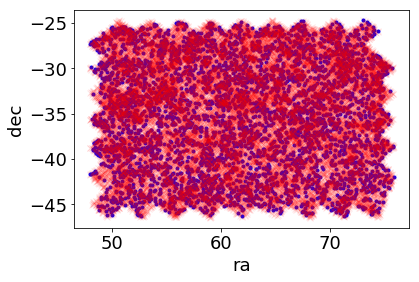

In [24]:
plt.plot(cluster_data['ra_cen_0'],cluster_data['dec_cen_0'],'b.')
plt.plot(truth_data['ra'],truth_data['dec'],'rx',alpha=0.1)
plt.xlabel("ra")
plt.ylabel("dec");

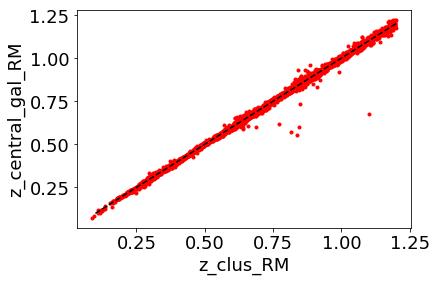

In [25]:
# Compare the cluster photo-z to the central galaxy redshift
plt.plot(cluster_data['redshift'], cluster_data['redshift_true_cg'], 'r.')
plt.plot([0.1, 1.2], [0.1, 1.2], 'k--')
plt.xlabel('z_clus_RM')
plt.ylabel('z_central_gal_RM');

# 2 - associate Redmapper detections to true DC2 halos

## geometrical matching : 
### Association of one object to another if it is the nearest (in projected distance) inside a cylinder defined by {$r_{max},\Delta_z=\delta_{zmax}\times(1+z_{object})$} 

In [26]:
#define same cosmological parameters as in the truth catalog (cosmoDC2)
cosmo = gc_truth.cosmology

### - 1rst association criteria : $\Delta_z=0.05, R_{max} = 0.75Mpc$ 

In [27]:
#criteria
match_num_1w_a, match_num_2w_a, ind_bij_a = volume_association(truth_data, cluster_data, 0.05, 0.75, "fixed", cosmo)
#truth_to_det_match_numbers, det_to_truth_match_number, bij_ind  

number of bijective associations 4689
number and fraction of fragmentation (6, 0.0012795905310300703)
number and fraction of overmerging (362, 0.07720196203881424)


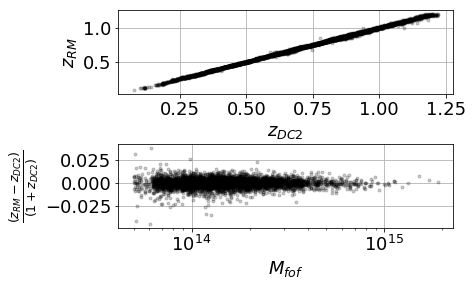

In [35]:
#statistics
print ("number of bijective associations", number_of_associations(truth_data, ind_bij_a))
print ("number and fraction of fragmentation", fragmentation(match_num_1w_a, truth_data, ind_bij_a, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w_a, truth_data, ind_bij_a, method="bij"))

#sanity check
plot_redshift_comparison(truth_data, cluster_data, ind_bij_a[:,1], ind_bij_a[:,0])

### - 2nd association criteria : $\Delta_z=0.05, R_{max} = 0.50Mpc$ 

In [36]:
#criteria
match_num_1w_b, match_num_2w_b, ind_bij_b = volume_association(truth_data, cluster_data, 0.05, 0.50, "fixed", cosmo)

number of bijective associations 4654
number and fraction of overmerging (201, 0.0431886549204985)
number and fraction of fragmentation (3, 0.0006446067898581865)


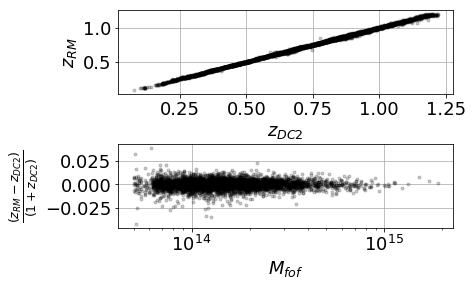

In [30]:
#statistics
print ("number of bijective associations", number_of_associations(truth_data, ind_bij_b))
print ("number and fraction of overmerging", overmerging(match_num_2w_b, truth_data, ind_bij_b, method="bij"))
print ("number and fraction of fragmentation", fragmentation(match_num_1w_b, truth_data, ind_bij_b, method="bij"))

#sanity check
plot_redshift_comparison(truth_data, cluster_data, ind_bij_b[:,1], ind_bij_b[:,0])


### - 3rd association criteria : $\Delta_z=0.05, R_{max} = R_{\tilde {fof}}$,  with $R_{\tilde {fof}} = \left[\frac{3}{4}\frac{M_{fof}}{200\pi\rho_c(z)}\right]^{1/3}$

In [31]:
#criteria
match_num_1w_fof_a, match_num_2w_fof_a, ind_bij_fof_a = volume_association(truth_data, cluster_data, 0.05, 1.00,"scaled", cosmo)

number of bijective associations 4690
number and fraction of overmerging (336, 0.07164179104477612)
number and fraction of fragmentation (9, 0.0019189765458422175)


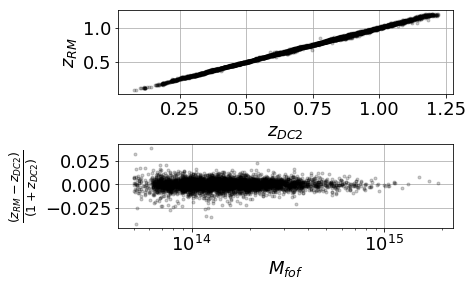

In [32]:
#statistics
print ("number of bijective associations", number_of_associations(truth_data, ind_bij_fof_a))
print ("number and fraction of overmerging", overmerging(match_num_2w_fof_a, truth_data, ind_bij_fof_a, method="bij"))
print ("number and fraction of fragmentation", fragmentation(match_num_1w_fof_a, truth_data, ind_bij_fof_a, method="bij"))

#sanity check
plot_redshift_comparison(truth_data, cluster_data, ind_bij_fof_a[:,1], ind_bij_fof_a[:,0])

### - 4rth association criteria : $\Delta_z=0.05, R_{max} =  0.5 \times R_{\tilde {fof}}$ 

In [33]:
#criteria
match_num_1w_fof_b, match_num_2w_fof_b, ind_bij_fof_b = volume_association(truth_data, cluster_data, 0.05, 0.50,"scaled", cosmo)

number of bijective associations 4603
number and fraction of overmerging (336, 0.07299587225722355)
number and fraction of fragmentation (0, 0.0)


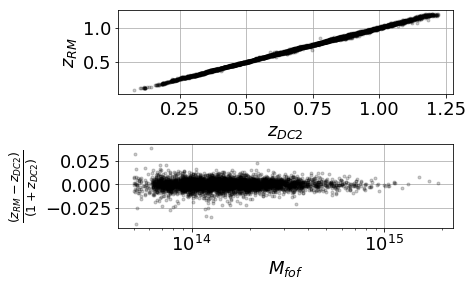

In [34]:
#statistics
print ("number of bijective associations", number_of_associations(truth_data, ind_bij_fof_b))
print ("number and fraction of overmerging", overmerging(match_num_2w_fof_b, truth_data, ind_bij_fof_b, method="bij"))
print ("number and fraction of fragmentation", fragmentation(match_num_1w_fof_b, truth_data, ind_bij_fof_b, method="bij"))

#sanity check
plot_redshift_comparison(truth_data, cluster_data, ind_bij_fof_b[:,1], ind_bij_fof_b[:,0])

# 3 - compute completeness

### completeness defined as : number of association/number of true halos

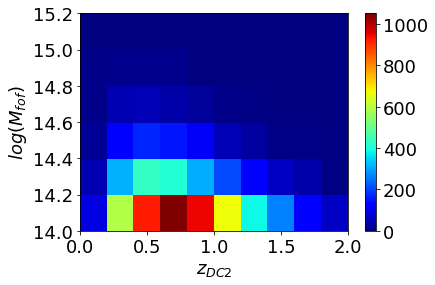

In [37]:
#number of true halos
bin_range = [[0,2],[14.,15.2]]
bins = [10,6]
num_min=20.

hist_num_cluster = plt.hist2d(truth_data['redshift'],np.log10(truth_data['halo_mass']),range=bin_range, bins= bins,cmap='jet');
plt.colorbar()
plt.xlabel('$z_{DC2}$')
plt.ylabel('$log(M_{fof})$');


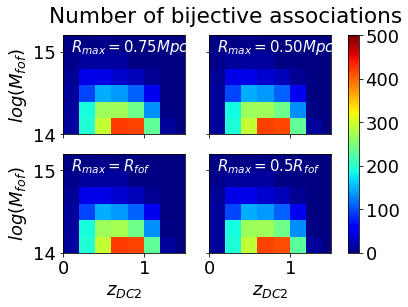

In [44]:
vmax = 500. #max value for colorbar

fig, axe = plt.subplots(2,2, sharex=True, sharey=True)

fig.suptitle('Number of bijective associations')

title = ['$R_{max}=0.75 Mpc$', '$R_{max}=0.50 Mpc$', '$R_{max}=R_{fof}$', '$R_{max}=0.5R_{fof}$']

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,15,title[k],color = "white",fontsize='small')
        k = k+1

hist_num_match1 = axe[0,0].hist2d(truth_data['redshift'][ind_bij_a[:,1]],np.log10(truth_data['halo_mass'][ind_bij_a[:,1]]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match2 = axe[0,1].hist2d(truth_data['redshift'][ind_bij_b[:,1]],np.log10(truth_data['halo_mass'][ind_bij_b[:,1]]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match3 = axe[1,0].hist2d(truth_data['redshift'][ind_bij_fof_a[:,1]],np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match4 = axe[1,1].hist2d(truth_data['redshift'][ind_bij_fof_b[:,1]],np.log10(truth_data['halo_mass'][ind_bij_fof_b[:,1]]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);

fig.colorbar(hist_num_match4[3], ax=axe.ravel().tolist())
axe[1,1].set_xlim(0,1.5)

axe[1,0].set_xlabel('$z_{DC2}$')
axe[1,1].set_xlabel('$z_{DC2}$')
axe[0,0].set_ylabel('$log(M_{fof})$')
axe[1,0].set_ylabel('$log(M_{fof})$');


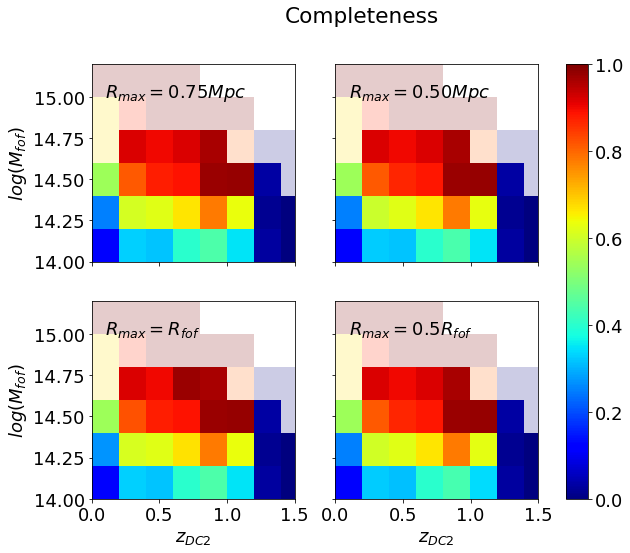

In [39]:
fig, axe = plt.subplots(2,2, sharex=True, sharey=True , figsize = (10,8))

fig.suptitle('Completeness')

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,15.,title[k])
        k = k+1
        
axe[0,0].imshow(hist_num_match1[0].T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[0,0].imshow(np.ma.masked_where(hist_num_cluster[0] < num_min, hist_num_match1[0]).T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');

axe[0,1].imshow(hist_num_match2[0].T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[0,1].imshow(np.ma.masked_where(hist_num_cluster[0] < num_min, hist_num_match2[0]).T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');

axe[1,0].imshow(hist_num_match3[0].T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[1,0].imshow(np.ma.masked_where(hist_num_cluster[0] < num_min, hist_num_match3[0]).T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');

axe[1,1].imshow(hist_num_match4[0].T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
im = axe[1,1].imshow(np.ma.masked_where(hist_num_cluster[0] < num_min, hist_num_match4[0]).T/hist_num_cluster[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');

fig.colorbar(im, ax=axe.ravel().tolist())
axe[1,1].set_xlim(0,1.5)

axe[1,0].set_xlabel('$z_{DC2}$')
axe[1,1].set_xlabel('$z_{DC2}$')
axe[0,0].set_ylabel('$log(M_{fof})$')
axe[1,0].set_ylabel('$log(M_{fof})$');

In [45]:
#mean completeness for each association criteria
print ('mean completeness at z<1.2 :',np.nanmean(hist_num_match1[0][0:6,:].T/hist_num_cluster[0][0:6,:].T))
print ('mean completeness at z<1.2 :',np.nanmean(hist_num_match2[0][0:6,:].T/hist_num_cluster[0][0:6,:].T))
print ('mean completeness at z<1.2 :',np.nanmean(hist_num_match3[0][0:6,:].T/hist_num_cluster[0][0:6,:].T))
print ('mean completeness at z<1.2 :',np.nanmean(hist_num_match4[0][0:6,:].T/hist_num_cluster[0][0:6,:].T))


mean completeness at z<1.2 : 0.74432000049764
mean completeness at z<1.2 : 0.7432632749483595
mean completeness at z<1.2 : 0.7470619523573776
mean completeness at z<1.2 : 0.7429231556641505


# 3 - compute purity

### completeness defined as : number of association/number of detections

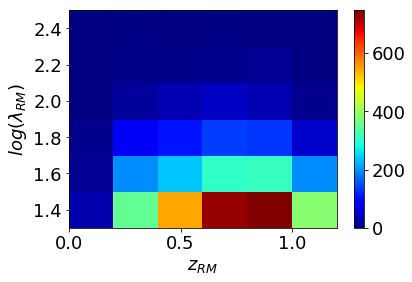

In [46]:
#total number of redmapper detections
bin_range2 = [[0,1.2],[1.3,2.5]]
bins2 = [6,6]

hist_num_det = plt.hist2d(cluster_data['redshift'],np.log10(cluster_data['richness']),range=bin_range2, bins= bins2,cmap='jet');
plt.colorbar()
plt.xlabel('$z_{RM}$')
plt.ylabel('$log(\lambda_{RM})$');

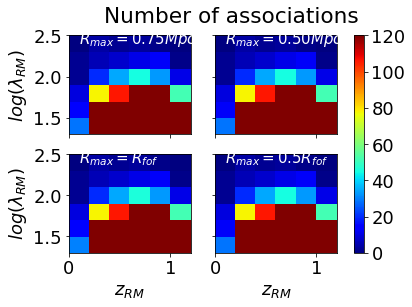

In [47]:
vmax = 120. #max value for colorbar

fig, axe = plt.subplots(2,2, sharex=True, sharey=True)

fig.suptitle('Number of associations')

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,2.4,title[k],color = "white",fontsize='small')
        k = k+1
        
hist2_num_match1 = axe[0,0].hist2d(cluster_data['redshift'][ind_bij_a[:,0]],np.log10(cluster_data['richness'][ind_bij_a[:,0]]),range=bin_range2, bins= bins2,cmap='jet',vmin = 0, vmax = vmax);
hist2_num_match2 = axe[0,1].hist2d(cluster_data['redshift'][ind_bij_b[:,0]],np.log10(cluster_data['richness'][ind_bij_b[:,0]]),range=bin_range2, bins= bins2,cmap='jet',vmin = 0, vmax = vmax);
hist2_num_match3 = axe[1,0].hist2d(cluster_data['redshift'][ind_bij_fof_a[:,0]],np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]]),range=bin_range2, bins= bins2,cmap='jet',vmin = 0, vmax = vmax);
hist2_num_match4 = axe[1,1].hist2d(cluster_data['redshift'][ind_bij_fof_b[:,0]],np.log10(cluster_data['richness'][ind_bij_fof_b[:,0]]),range=bin_range2, bins= bins2,cmap='jet',vmin = 0, vmax = vmax);

fig.colorbar(hist2_num_match4[3], ax=axe.ravel().tolist())

axe[1,0].set_xlabel('$z_{RM}$')
axe[1,1].set_xlabel('$z_{RM}$')
axe[0,0].set_ylabel('$log(\lambda_{RM})$')
axe[1,0].set_ylabel('$log(\lambda_{RM})$');


In [50]:
#if the loaded truth catalog is smaller in area than the detection catalog the purity will be artificially low
#in practice one should precisely compute the overlapping area

scale = gc.sky_area / gc_truth.sky_area    
print (scale)    

0.9999999997938741


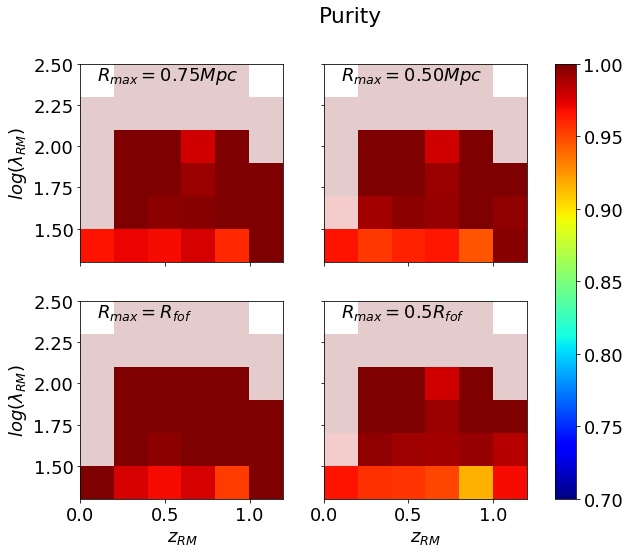

In [51]:
fig, axe = plt.subplots(2,2, sharex=True, sharey=True, figsize = (10,8))

fig.suptitle('Purity')

vmin_p = 0.7

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,2.4,title[k])
        k = k+1

axe[0,0].imshow(scale * hist2_num_match1[0].T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2)
axe[0,0].imshow(scale * np.ma.masked_where(hist_num_det[0] < num_min, hist2_num_match1[0]).T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=vmin_p,vmax=1,cmap='jet')

axe[0,1].imshow(scale * hist2_num_match2[0].T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2)
axe[0,1].imshow(scale * np.ma.masked_where(hist_num_det[0] < num_min, hist2_num_match2[0]).T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=vmin_p,vmax=1,cmap='jet')

axe[1,0].imshow(scale * hist2_num_match3[0].T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2)
axe[1,0].imshow(scale * np.ma.masked_where(hist_num_det[0] < num_min, hist2_num_match3[0]).T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=vmin_p,vmax=1,cmap='jet')

axe[1,1].imshow(scale * hist2_num_match4[0].T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2)
im = axe[1,1].imshow(scale * np.ma.masked_where(hist_num_det[0] < num_min, hist2_num_match4[0]).T/hist_num_det[0].T,origin = 'lower',aspect='auto',extent = [bin_range2[0][0],bin_range2[0][1],bin_range2[1][0],bin_range2[1][1]],vmin=vmin_p,vmax=1,cmap='jet')

fig.colorbar(im, ax=axe.ravel().tolist())

axe[1,0].set_xlabel('$z_{RM}$')
axe[1,1].set_xlabel('$z_{RM}$')
axe[0,0].set_ylabel('$log(\lambda_{RM})$')
axe[1,0].set_ylabel('$log(\lambda_{RM})$');

In [52]:
#mean purity for each association criteria

print ('mean purity at z<1.2 :',scale * np.nanmean(hist2_num_match1[0].T/hist_num_det[0].T))
print ('mean purity at z<1.2 :',scale * np.nanmean(hist2_num_match2[0].T/hist_num_det[0].T))
print ('mean purity at z<1.2 :',scale * np.nanmean(hist2_num_match3[0].T/hist_num_det[0].T))
print ('mean purity at z<1.2 :',scale * np.nanmean(hist2_num_match4[0].T/hist_num_det[0].T))

mean purity at z<1.2 : 0.9943348205683534
mean purity at z<1.2 : 0.9901412412064642
mean purity at z<1.2 : 0.9962342498684074
mean purity at z<1.2 : 0.9873538329484048


# 4 - mass-richness relations

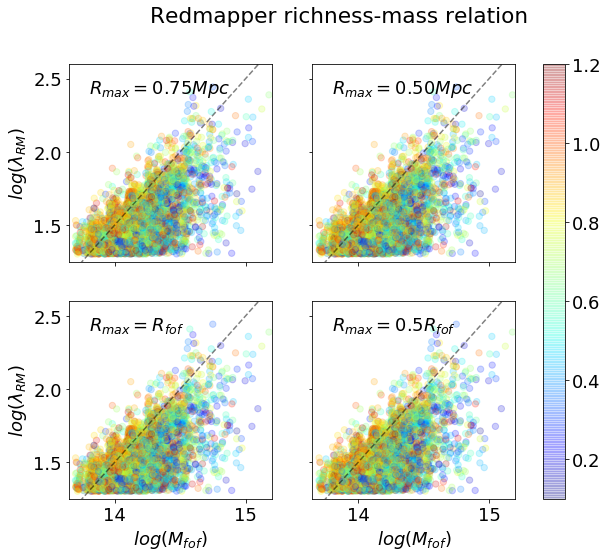

In [53]:
fig, axe = plt.subplots(2,2, sharex=True, sharey=True, figsize = (10,8))

fig.suptitle('Redmapper richness-mass relation')

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(13.8,2.4,title[k])
        k = k+1        
        
axe[0,0].scatter(np.log10(truth_data['halo_mass'][ind_bij_a[:,1]]),np.log10(cluster_data['richness'][ind_bij_a[:,0]]),c=truth_data['redshift'][ind_bij_a[:,1]],s=40,cmap='jet',vmin = 0.1, vmax = 1.2,alpha=0.2)
axe[0,1].scatter(np.log10(truth_data['halo_mass'][ind_bij_b[:,1]]),np.log10(cluster_data['richness'][ind_bij_b[:,0]]),c=truth_data['redshift'][ind_bij_b[:,1]],s=40,cmap='jet',vmin = 0.1, vmax = 1.2,alpha=0.2)
axe[1,0].scatter(np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]]),np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]]),c=truth_data['redshift'][ind_bij_fof_a[:,1]],s=40,cmap='jet',alpha=0.2,vmin = 0.1, vmax = 1.2)
im = axe[1,1].scatter(np.log10(truth_data['halo_mass'][ind_bij_fof_b[:,1]]),np.log10(cluster_data['richness'][ind_bij_fof_b[:,0]]),c=truth_data['redshift'][ind_bij_fof_b[:,1]],s=40,cmap='jet',alpha=0.2,vmin = 0.1, vmax = 1.2)

fig.colorbar(im, ax=axe.ravel().tolist())

#add an arbitrary power law with slope = 1 for vizualisation purpose
x = np.linspace(13.65,15.2,20)
zp,slope = -12.5, 1.0

for i in range(2):
    for j in range(2):
        axe[i,j].plot(x,zp+x*(slope),'k--',alpha=0.5,label='$N_{gal}\propto M_{h}$ relation')
        
axe[0,0].set_ylim(1.25,2.6)
axe[0,0].set_xlim(13.65,15.2)
    
axe[1,0].set_xlabel('$log(M_{fof})$')
axe[1,1].set_xlabel('$log(M_{fof})$');
axe[0,0].set_ylabel('$log(\lambda_{RM})$')
axe[1,0].set_ylabel('$log(\lambda_{RM})$');

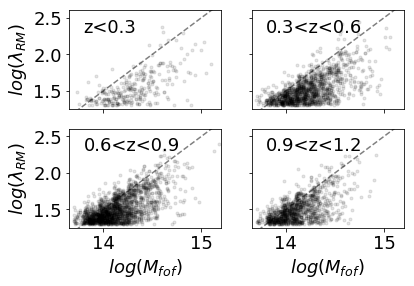

In [54]:
f, ax = plt.subplots(2,2, sharex=True, sharey=True)

#f.suptitle('Redmapper richness-mass relation in different redshift bins \n example for association criteria 1')

z = truth_data['redshift'][ind_bij_fof_a[:,1]]
label = ['z<0.3','0.3<z<0.6','0.6<z<0.9','0.9<z<1.2']

ax[0,0].plot(np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]][z<0.3]),np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]][z<0.3]),'k.',alpha=0.1)
ax[0,1].plot(np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]][(z>0.3)*(z<0.6)]),np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]][(z>0.3)*(z<0.6)]),'k.',alpha=0.1)
ax[1,0].plot(np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]][(z>0.6)*(z<0.9)]),np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]][(z>0.6)*(z<0.9)]),'k.',alpha=0.1)
ax[1,1].plot(np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]][(z>0.9)*(z<1.2)]),np.log10(cluster_data['richness'][ind_bij_fof_a[:,0]][(z>0.9)*(z<1.2)]),'k.',alpha=0.1)

k = 0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(x,zp+x*(slope),'k--',alpha=0.5,label='$N_{gal}\propto M_{h}$ relation')
        ax[i,j].text(13.8,2.3,label[k])
        k = k+1
        
ax[0,0].set_ylim(1.25,2.6)
ax[0,0].set_xlim(13.65,15.2)

ax[1,0].set_xlabel('$log(M_{fof})$')
ax[1,1].set_xlabel('$log(M_{fof})$');
ax[0,0].set_ylabel('$log(\lambda_{RM})$')
ax[1,0].set_ylabel('$log(\lambda_{RM})$');

# 5 - centering

In [55]:
#association of DC2 centrals to Redmapper centrals
ind_a1, ind_a2 = esutil.numpy_util.match(cluster_data['id_cen_0'][ind_bij_a[:,0]],truth_data['galaxy_id'][ind_bij_a[:,1]])
ind_b1, ind_b2 = esutil.numpy_util.match(cluster_data['id_cen_0'][ind_bij_b[:,0]],truth_data['galaxy_id'][ind_bij_b[:,1]])
ind_fof_a1, ind_fof_a2 = esutil.numpy_util.match(cluster_data['id_cen_0'][ind_bij_fof_a[:,0]],truth_data['galaxy_id'][ind_bij_fof_a[:,1]])
ind_fof_b1, ind_fof_b2 = esutil.numpy_util.match(cluster_data['id_cen_0'][ind_bij_fof_b[:,0]],truth_data['galaxy_id'][ind_bij_fof_b[:,1]])

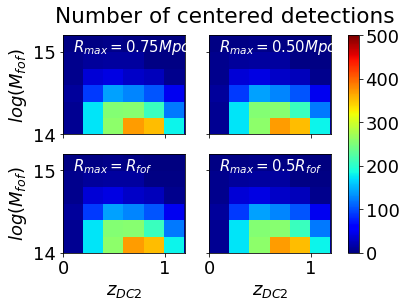

In [61]:
vmax = 500. #max value for colorbar

fig, axe = plt.subplots(2,2, sharex=True, sharey=True)

fig.suptitle('Number of centered detections')

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,15,title[k],color = "white",fontsize='small')
        k = k+1

hist_num_match_cen1 = axe[0,0].hist2d(truth_data['redshift'][ind_bij_a[:,1]][ind_a2],np.log10(truth_data['halo_mass'][ind_bij_a[:,1]][ind_a2]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match_cen2 = axe[0,1].hist2d(truth_data['redshift'][ind_bij_b[:,1]][ind_b2],np.log10(truth_data['halo_mass'][ind_bij_b[:,1]][ind_b2]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match_cen3 = axe[1,0].hist2d(truth_data['redshift'][ind_bij_fof_a[:,1]][ind_fof_a2],np.log10(truth_data['halo_mass'][ind_bij_fof_a[:,1]][ind_fof_a2]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);
hist_num_match_cen4 = axe[1,1].hist2d(truth_data['redshift'][ind_bij_fof_b[:,1]][ind_fof_b2],np.log10(truth_data['halo_mass'][ind_bij_fof_b[:,1]][ind_fof_b2]),range=bin_range, bins= bins,cmap='jet',vmin = 0, vmax = vmax);

fig.colorbar(hist_num_match_cen4[3], ax=axe.ravel().tolist())

axe[1,0].set_xlim(0,1.2)

axe[1,0].set_xlabel('$z_{DC2}$')
axe[1,1].set_xlabel('$z_{DC2}$')
axe[0,0].set_ylabel('$log(M_{fof})$')
axe[1,0].set_ylabel('$log(M_{fof})$');

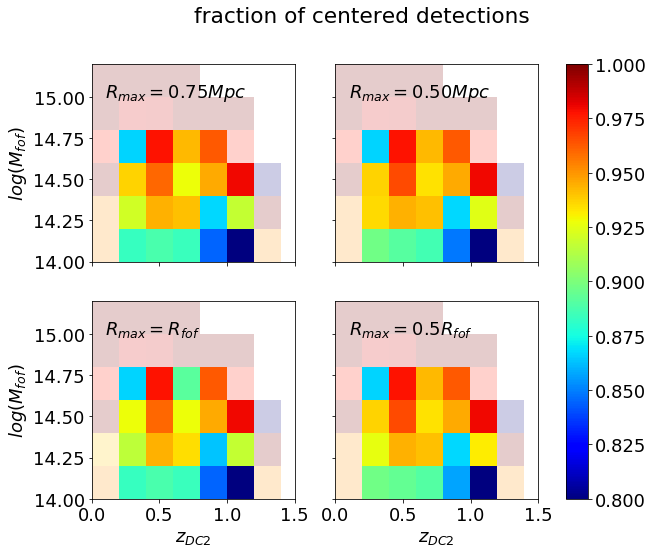

In [60]:
fig, axe = plt.subplots(2,2, sharex=True, sharey=True , figsize = (10,8))

fig.suptitle('fraction of centered detections')

vmin_c = 0.8

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,15.,title[k])
        k = k+1
        
axe[0,0].imshow(hist_num_match_cen1[0].T/hist_num_match1[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[0,0].imshow(np.ma.masked_where(hist_num_match1[0] < num_min, hist_num_match_cen1[0]).T/hist_num_match1[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin_c,vmax=1,cmap='jet');

axe[0,1].imshow(hist_num_match_cen2[0].T/hist_num_match2[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[0,1].imshow(np.ma.masked_where(hist_num_match2[0] < num_min, hist_num_match_cen2[0]).T/hist_num_match2[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin_c,vmax=1,cmap='jet');

axe[1,0].imshow(hist_num_match_cen3[0].T/hist_num_match3[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
axe[1,0].imshow(np.ma.masked_where(hist_num_match3[0] < num_min, hist_num_match_cen3[0]).T/hist_num_match3[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin_c,vmax=1,cmap='jet');

axe[1,1].imshow(hist_num_match_cen4[0].T/hist_num_match4[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet',alpha=0.2);
im = axe[1,1].imshow(np.ma.masked_where(hist_num_match4[0] < num_min, hist_num_match_cen4[0]).T/hist_num_match4[0].T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=vmin_c,vmax=1,cmap='jet');

fig.colorbar(im, ax=axe.ravel().tolist())
axe[1,1].set_xlim(0,1.5)

axe[1,0].set_xlabel('$z_{DC2}$')
axe[1,1].set_xlabel('$z_{DC2}$')
axe[0,0].set_ylabel('$log(M_{fof})$')
axe[1,0].set_ylabel('$log(M_{fof})$');

In [ ]:
#mean centred fraction for each association criteria

hist_num_match_cen1[0].T/hist_num_match1[0].T

print ('mean centred fraction at z<1.2 :',np.nanmean(hist_num_match_cen1[0][0:6,:].T/hist_num_match1[0][0:6,:].T))
print ('mean centred fraction at z<1.2 :',np.nanmean(hist_num_match_cen2[0][0:6,:].T/hist_num_match2[0][0:6,:].T))
print ('mean centred fraction at z<1.2 :',np.nanmean(hist_num_match_cen3[0][0:6,:].T/hist_num_match3[0][0:6,:].T))
print ('mean centred fraction at z<1.2 :',np.nanmean(hist_num_match_cen4[0][0:6,:].T/hist_num_match4[0][0:6,:].T))

In [ ]:
#offset between DC2 central and RM detection centre for macthed cases
coo_DC2 = SkyCoord(truth_data['ra']*u.deg, truth_data['dec']*u.deg)
coo_RM = SkyCoord(cluster_data['ra']*u.deg, cluster_data['dec']*u.deg)

dist_to_central_arcmin1 = coo_DC2[ind_bij_a[:,1]].separation(coo_RM[ind_bij_a[:,0]]).arcmin*u.arcmin
dist_to_central_Mpc1 = (cosmo.kpc_proper_per_arcmin(truth_data['redshift'][ind_bij_a[:,1]])*dist_to_central_arcmin1/1e3).value

dist_to_central_arcmin2 = coo_DC2[ind_bij_b[:,1]].separation(coo_RM[ind_bij_b[:,0]]).arcmin*u.arcmin
dist_to_central_Mpc2 = (cosmo.kpc_proper_per_arcmin(truth_data['redshift'][ind_bij_b[:,1]])*dist_to_central_arcmin2/1e3).value

dist_to_central_arcmin3 = coo_DC2[ind_bij_fof_a[:,1]].separation(coo_RM[ind_bij_fof_a[:,0]]).arcmin*u.arcmin
dist_to_central_Mpc3 = (cosmo.kpc_proper_per_arcmin(truth_data['redshift'][ind_bij_fof_a[:,1]])*dist_to_central_arcmin3/1e3).value

dist_to_central_arcmin4 = coo_DC2[ind_bij_fof_b[:,1]].separation(coo_RM[ind_bij_fof_b[:,0]]).arcmin*u.arcmin
dist_to_central_Mpc4 = (cosmo.kpc_proper_per_arcmin(truth_data['redshift'][ind_bij_fof_b[:,1]])*dist_to_central_arcmin4/1e3).value

fig, axe = plt.subplots(2,2, sharex=True, sharey=True , figsize = (10,8))

fig.suptitle('offset between DC2 central and RM detection centre')

k = 0
for i in range(2):
    for j in range(2):
        axe[i,j].text(0.1,1e3,title[k])
        k = k+1
        
axe[0,0].hist(dist_to_central_Mpc1,bins=22,range=[0,1.1])
axe[0,1].hist(dist_to_central_Mpc2,bins=22,range=[0,1.1])
axe[1,0].hist(dist_to_central_Mpc3,bins=22,range=[0,1.1])
axe[1,1].hist(dist_to_central_Mpc4,bins=22,range=[0,1.1])

axe[1,1].set_yscale('log')

axe[1,0].set_xlabel('offset (Mpc)')
axe[1,1].set_xlabel('offset (Mpc)');
